# **Без будущего**

# Колдунство высокого уровня

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install tensorflow-gpu==2.0

## Библиотеки ставим да дескрипторы указываем

In [0]:
import sklearn
import cv2
import pandas as pd
import numpy as np

In [0]:
descriptors={'surf': cv2.xfeatures2d.SURF_create().detect,
             'sift': cv2.xfeatures2d.SIFT_create().detect,
             'akaze': cv2.AKAZE_create().detect}

## Данные грузим, знаки дорожные

In [4]:
! git clone https://github.com/tupoylogin/CVPR_Lab_2.git

fatal: destination path 'CVPR_Lab_2' already exists and is not an empty directory.


In [0]:
import os

basePath = os.path.join(os.curdir,'CVPR_Lab_2')

def load_split(basePath, csvPath):
    
    from sklearn.utils import shuffle
    
    # initialize the list of data and labels
    data = []
    labels = []
 
    # load the contents of the CSV file, remove the first line (since
    # it contains the CSV header), and shuffle the rows (otherwise
    # all examples of a particular class will be in sequential order)
    
    rows_df = pd.read_csv(csvPath)[['ClassId','Path']]
    
    # loop over the rows of the CSV file
    for row in rows_df.values:
        # check to see if we should show a status update
        (label, imagePath) = row[0], row[1]
 
        # derive the full path to the image file and load it
        imagePath = os.path.sep.join([basePath, imagePath])
        image = cv2.imread(imagePath)
         # resize the image to be 64x64 pixels, ignoring aspect ratio,
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        # and then perform Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=0.1)
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
        #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # convert the YUV image back to RGB format
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
       
        
        
        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(label))
 
    # convert the data and labels to NumPy arrays
    data = np.array(data)
    
 
    # return a tuple of the data and labels
    return rows_df, data

In [0]:
train, data = load_split(basePath,os.path.join(basePath, 'Train.csv'))

In [7]:
train.head(5)

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

### 11 шакалов из 10

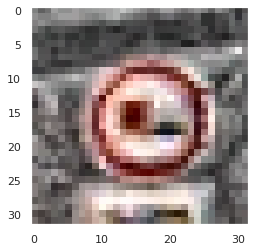

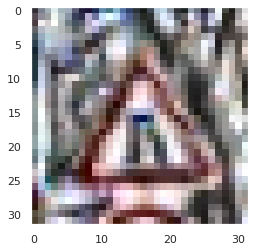

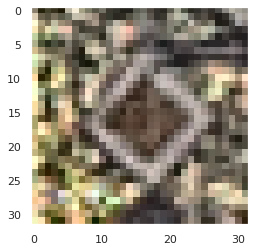

<Figure size 432x288 with 0 Axes>

In [53]:
sns.set()
with sns.axes_style({'axes.grid': False}):
  for idx in np.random.choice(train.ClassId.shape[0],3):
    plt.imshow(data[idx]),plt.show()
    plt.figure(idx+1)

## Точки ключевые берем

In [0]:
def get_key_pts(algorithm,img,verbose=False):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp = algorithm(gray,None)
    return np.array([kp[idx].pt for idx in range(0, len(kp))]).flatten()

def to_same_dims(array, dim):
  # kp = np.zeros([len(array),len(max(array,key = lambda x: len(x)))])
  kp = np.zeros([len(array),dim])
  for i,j in enumerate(array):
      if len(j)>dim:
        kp[i][0:dim] = j[0:dim]
      else:
        kp[i][0:len(j)] = j
  return kp

## SIFT - наш выбор, ему малые изображения не страшны

In [0]:
keyp_array_train = []
for img in data:
    kp = get_key_pts(descriptors['sift'], img)
    keyp_array_train.append(kp)

keyp_array_train = to_same_dims(keyp_array_train,256)

In [0]:
test, test_data = load_split(basePath,os.path.join(basePath, 'Test.csv'))

keyp_array_test = []
for img in test_data:
    kp = get_key_pts(descriptors['sift'], img)
    keyp_array_test.append(kp)

keyp_array_test = to_same_dims(keyp_array_test,256)

## Приводим все к размерам малым

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
sc = MinMaxScaler()

keyp_array_train = sc.fit_transform(keyp_array_train)
keyp_array_test = sc.transform(keyp_array_test)

# А вот и нейроночки

In [15]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

batch_size = 32
num_classes = train['ClassId'].unique().shape[0]

# The data, split between train and test sets:
print('x_train shape:', data.shape)
print(data.shape[0], 'train samples')
print(test_data.shape[0], 'test samples')

#height, width = data.shape[1:]
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(train['ClassId'].values, num_classes)
y_test = tf.keras.utils.to_categorical(test['ClassId'].values, num_classes)
x_train = data.astype('float32')
x_test = test_data.astype('float32')
x_train /= 255
x_test /= 255
#uncomment for grayscale imgs
#x_train = x_train.reshape((x_train.shape[0], height, width,1))
#x_test = x_test.reshape((x_test.shape[0], height, width,1))
 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train['ClassId']),
                                                 train['ClassId'])

class_weights = dict(enumerate(class_weights))

x_train shape: (39209, 32, 32, 3)
39209 train samples
12630 test samples


In [0]:
K.clear_session()

In [0]:
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Flatten, Dropout, Dense
import tensorflow.keras.backend as K

class MetricsAtTopK:
  def __init__(self, k):
    self.k = k

  def _get_prediction_tensor(self, y_pred):
    """
    Takes y_pred and creates a tensor of same shape with 1 in indices 
    where the values are in top_k
    """
    topk_values, topk_indices = tf.nn.top_k(y_pred, k=self.k, sorted=False, 
                                            name="topk")
    # the topk_indices are along last axis (1). Add indices for axis=0
    ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(self.k), 
                        indexing='ij')
    index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), 
                                                      shape=(-1, 2))
    prediction_tensor = tf.compat.v1.sparse_to_dense(sparse_indices=index_tensor,
                                               output_shape=tf.shape(y_pred),
                                               default_value=0,
                                               sparse_values=1.0,
                                               validate_indices=False
                                               )
    prediction_tensor = tf.cast(prediction_tensor, K.floatx())
    return prediction_tensor

  def true_positives_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    return true_positive

  def false_positives_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c2 = K.sum(prediction_tensor)  # TP + FP
    false_positive = c2 - true_positive
    return false_positive

  def false_negatives_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c3 = K.sum(y_true)  # TP + FN
    false_negative = c3 - true_positive
    return false_negative

  def precision_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c2 = K.sum(prediction_tensor)  # TP + FP
    return true_positive/(c2+K.epsilon())

  def recall_at_k(self, y_true, y_pred):
    prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
    true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
    c3 = K.sum(y_true)  # TP + FN
    return true_positive/(c3+K.epsilon())

  def f1_at_k(self, y_true, y_pred):
    precision = self.precision_at_k(y_true=y_true, y_pred=y_pred)
    recall = self.recall_at_k(y_true=y_true, y_pred=y_pred)
    f1 = (2*precision*recall)/(precision+recall+K.epsilon())
    return f1

metrics = MetricsAtTopK(k=5)

def load_model(x_train, num_classes):

  model = Sequential()
  model.add(Conv2D(8, (5, 5), padding='same', 
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))	

  model.add(Conv2D(16, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(16, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
 
	# softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))

  # initiate Adam optimizer
  opt = Adam(learning_rate=1e-3, decay=1e-3/32)

  # Let's train the model using Adam
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy',
                #tf.keras.metrics.CategoricalAccuracy(),
                metrics.recall_at_k,
                metrics.precision_at_k,
                metrics.f1_at_k])
  
  return model

In [0]:
model = load_model(x_train=x_train, num_classes=num_classes)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

## Пути назад уже нет!

In [24]:
#reducing learning rate if model is on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.2,
                                                         patience=5, 
                                                         min_lr=1e-5)

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
          rotation_range=10,
          zoom_range=0.3,
	        width_shift_range=0.1,
	        height_shift_range=0.1,
	        shear_range=0.15,
	        horizontal_flip=False,
	        vertical_flip=False,
	        fill_mode="nearest")

#datagen.fit(x_train)

H = model.fit_generator(datagen.flow(x_train, y_train,
                                      batch_size=64),
                          epochs=10, 
                          #class_weight=class_weights,
                          steps_per_epoch=x_train.shape[0]//64,
                          validation_data=(x_test, y_test),
                          callbacks=[reduce_lr],verbose=1)

Epoch 1/10
612/612 [==============================] - 98s 160ms/step - loss: 2.9178 - accuracy: 0.2378 - recall_at_k: 0.5570 - precision_at_k: 0.1114 - f1_at_k: 0.1857 - val_loss: 1.7499 - val_accuracy: 0.4283 - val_recall_at_k: 0.8209 - val_precision_at_k: 0.1642 - val_f1_at_k: 0.2736
Epoch 2/10
612/612 [==============================] - 95s 155ms/step - loss: 1.6952 - accuracy: 0.4585 - recall_at_k: 0.8367 - precision_at_k: 0.1673 - f1_at_k: 0.2789 - val_loss: 1.2443 - val_accuracy: 0.5816 - val_recall_at_k: 0.9128 - val_precision_at_k: 0.1826 - val_f1_at_k: 0.3043
Epoch 3/10
612/612 [==============================] - 96s 157ms/step - loss: 1.3071 - accuracy: 0.5734 - recall_at_k: 0.9073 - precision_at_k: 0.1815 - f1_at_k: 0.3024 - val_loss: 1.1461 - val_accuracy: 0.6161 - val_recall_at_k: 0.9362 - val_precision_at_k: 0.1872 - val_f1_at_k: 0.3121
Epoch 4/10
612/612 [==============================] - 98s 160ms/step - loss: 1.0427 - accuracy: 0.6589 - recall_at_k: 0.9424 - precision_at

In [25]:
# Score trained model.
y_pred = model.predict(x_test,batch_size=batch_size)
print(classification_report(np.argmax(y_test,axis=-1),
	                          np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.88      0.48      0.62        60
           1       0.92      0.93      0.93       720
           2       0.95      0.90      0.93       750
           3       0.99      0.60      0.74       450
           4       0.98      0.94      0.96       660
           5       0.71      0.71      0.71       630
           6       0.95      0.95      0.95       150
           7       0.58      0.48      0.53       450
           8       0.54      0.95      0.69       450
           9       0.91      0.99      0.95       480
          10       0.96      0.97      0.96       660
          11       0.88      0.95      0.91       420
          12       0.97      0.89      0.93       690
          13       0.96      1.00      0.98       720
          14       0.94      1.00      0.97       270
          15       0.86      0.94      0.90       210
          16       0.93      0.91      0.92       150
          17       1.00    

### Теперь показываем сети веса каждого класса для улучшения recall

In [29]:
H1 = model.fit_generator(datagen.flow(x_train, y_train,
                                      batch_size=64),
                          epochs=20, 
                          class_weight=class_weights,
                          steps_per_epoch=x_train.shape[0]//64,
                          validation_data=(x_test, y_test),
                          callbacks=[reduce_lr],verbose=1)

Epoch 1/20
612/612 [==============================] - 104s 170ms/step - loss: 0.6418 - accuracy: 0.8111 - recall_at_k: 0.9827 - precision_at_k: 0.1965 - f1_at_k: 0.3276 - val_loss: 0.4110 - val_accuracy: 0.8649 - val_recall_at_k: 0.9866 - val_precision_at_k: 0.1973 - val_f1_at_k: 0.3289
Epoch 2/20
612/612 [==============================] - 105s 171ms/step - loss: 0.5625 - accuracy: 0.8216 - recall_at_k: 0.9840 - precision_at_k: 0.1968 - f1_at_k: 0.3280 - val_loss: 0.5736 - val_accuracy: 0.8214 - val_recall_at_k: 0.9779 - val_precision_at_k: 0.1956 - val_f1_at_k: 0.3260
Epoch 3/20
612/612 [==============================] - 104s 170ms/step - loss: 0.5133 - accuracy: 0.8356 - recall_at_k: 0.9850 - precision_at_k: 0.1970 - f1_at_k: 0.3283 - val_loss: 0.4219 - val_accuracy: 0.8683 - val_recall_at_k: 0.9851 - val_precision_at_k: 0.1970 - val_f1_at_k: 0.3284
Epoch 4/20
612/612 [==============================] - 103s 169ms/step - loss: 0.4715 - accuracy: 0.8419 - recall_at_k: 0.9857 - precisio

In [30]:
# Score trained model.
y_pred = model.predict(x_test,batch_size=batch_size)
print(classification_report(np.argmax(y_test,axis=-1),
	                          np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89        60
           1       0.95      0.97      0.96       720
           2       0.90      0.97      0.94       750
           3       0.98      0.81      0.88       450
           4       0.98      0.94      0.96       660
           5       0.87      0.85      0.86       630
           6       0.99      0.93      0.96       150
           7       0.92      0.84      0.88       450
           8       0.85      0.96      0.90       450
           9       0.98      0.97      0.97       480
          10       0.98      0.96      0.97       660
          11       0.97      0.91      0.94       420
          12       0.98      0.94      0.96       690
          13       1.00      0.99      0.99       720
          14       0.96      1.00      0.98       270
          15       0.87      0.98      0.92       210
          16       0.88      1.00      0.93       150
          17       1.00    

### Да свершится предначертанное (на графике)

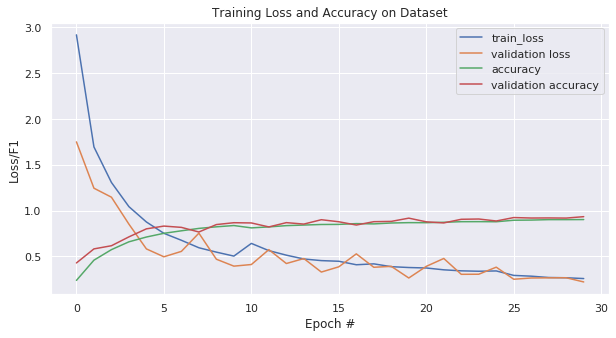

In [39]:
%matplotlib inline

epochs = np.arange(len(H.epoch)+len(H1.epoch))
history = dict()
for key in H.history.keys():
  history[key]=np.concatenate((H.history[key], H1.history[key]))

sns.set()
plt.figure(figsize=(10,5))
plt.plot(epochs, history["loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="validation loss")
plt.plot(epochs, history["accuracy"], label="accuracy")
plt.plot(epochs, history["val_accuracy"], label="validation accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/F1")
plt.legend(loc="upper right")

### **Выводы:** слова здесь излишни. Сеть даёт очень хорошие показатели по всем метрикам.

## Сеть с встроенным дескриптором

In [0]:
from tensorflow.keras.layers import Lambda

def load_desc_model(x_train=x_train, num_classes=num_classes, 
                    descriptor=descriptor):
  #for computing features
  @tf.function
  def get_key_pts(img):
    img = np.array(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray*=255
    img_ = gray.astype(np.uint8)
    kp = descriptor(img_,None)
    arr = np.array([kp[idx].pt for idx in range(0, len(kp))]).flatten()
    if arr.shape[0]<256:
      arr[len(arr):256]=0
    elif arr.shape[0]>256:
      arr=arr[:256]
    return tf.convert_to_tensor(arr, dtype=tf.float32)
  
  model = Sequential()
  model.add(Activation('relu',input_shape=x_train.shape[1:]))
  model.add(Lambda(get_key_pts))
  model.add(BatchNormalization())

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(128))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
 
	# softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))

  # initiate Adam optimizer
  opt = Adam(learning_rate=1e-3, decay=1e-3/32)

  # Let's train the model using Adam
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy',
                #tf.keras.metrics.CategoricalAccuracy(),
                metrics.recall_at_k,
                metrics.precision_at_k,
                metrics.f1_at_k])
  
  return model


In [79]:
model_desc = load_desc_model(x_train=x_train, num_classes=num_classes, 
                             descriptor=descriptors['sift'])


NotImplementedError: ignored

array([[ 80,  96,  96, ...,  72,  80,  48],
       [ 80,  80,  80, ..., 112, 143,  64],
       [ 80,  64,  64, ..., 147, 175,  96],
       ...,
       [ 84, 100, 116, ..., 146, 140,  48],
       [ 96, 143, 128, ..., 203, 175,  64],
       [ 96, 128, 128, ..., 251, 191, 112]], dtype=uint8)